# PyTorch🔥RNN - Predict Family Name Origins with vanilla RNN Model

Subject: Predicting the Language Origin of family names with a custom vanilla RNN Model (no LSTM layer/cells).

Data: Family Names in 18 Languages (from pytorch tutorial)

Procedure:

- Using string.ascii_letters list as a simple vocabulary
- Tokenizing characters in the family names
- Tensorizing train and target, with targets being the 18 languages
- Creating a torch.utils.data.TensorDataset and torch.utils.data.DataLoader
- Creating torch.nn.module model with torch.nn.Linear, torch.nn.LogSoftmax, and torch.tanh
- Training with torch.nn.CrossEntropyLoss, torch.optim.Adam, and hidden state tensors for storing the state in between a sequence
- Visualization of losses with pyplot
- Evaluation by classifying arbitrary input family names
- Quite encouraging results

Others:
- CUDA support
- working on Colab with Google Drive for loading data

Sources used:
- https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html  (includes dataset)

In [1]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Running on {DEVICE}')

if IN_COLAB := 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')
  BASE_PATH = './drive/MyDrive/Colab/'
  !pip install torchviz

else:
  BASE_PATH = '../'

Running on cuda
Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=f6fc61bb00e25818f301118c2b299d2c9e56a46af72875ea73f9cc4811ddd61a
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
from io import open
import glob
import os
import unicodedata
import string
import time
import math
import random

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Data Preparation
### Reading Files

In [3]:
# Some helper functions

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(f'All {n_letters} letters: {all_letters}')

def findFiles(path):
    return glob.glob(path)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(f'Ślusàrski -> {unicodeToAscii("Ślusàrski")}')

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

All 57 letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Ślusàrski -> Slusarski


In [5]:
# list of all languages we have a .txt file for
all_categories = []

# map from language to list of all names
category_lines = {}

for filename in findFiles(BASE_PATH + 'data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# print some example names for 'Italian'
print(category_lines['Italian'][400:415])

['Mantovani', 'Marchegiano', 'Marchesi', 'Marchetti', 'Marchioni', 'Marconi', 'Mari', 'Maria', 'Mariani', 'Marino', 'Marmo', 'Martelli', 'Martinelli', 'Masi', 'Masin']


### Convert Names to Tensors
To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

In [17]:
# get letter index, e.g. "a" -> 0
def letterToIndex(letter: str) -> int:
    return all_letters.find(letter)

# turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor.to(DEVICE)

print(f"'J' -> {letterToTensor('J')}")  # [1, 57]

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.to(DEVICE)


print(f"'Jones' -> {lineToTensor('Jones')}")  # [5, 1, 57] torch.float32

'J' -> tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
'Jones' -> tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
 

## Model

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.input_to_hidden = nn.Linear(in_features=input_size,
                                         out_features=hidden_size)
        self.hidden_to_hidden = nn.Linear(in_features=hidden_size,
                                          out_features=hidden_size)
        self.hidden_to_output = nn.Linear(in_features=hidden_size,
                                          out_features=output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self,
                input: torch.Tensor,
                hidden: torch.Tensor):

        input_1 = self.input_to_hidden(input)
        hidden_1 = self.hidden_to_hidden(hidden)

        hidden_2 = torch.tanh(input_1 + hidden_1)

        output_1 = self.hidden_to_output(hidden_2)

        return output_1, hidden_2

    def initHidden(self):
        return torch.zeros(1, self.hidden_size).to(DEVICE)

n_hidden = 128
rnn = RNN(input_size=n_letters, hidden_size=n_hidden, output_size=len(all_categories)).to(DEVICE)

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [18]:
# Let's try for 'Jones' with the untrained Model
input = letterToTensor('J').to(DEVICE)  # [1, 57]
hidden = torch.zeros(1, n_hidden).to(DEVICE)  # [1, 128]

output, next_hidden = rnn(input, hidden)  # output: [1, 18]  next_hidden: [1, 128]
print(f"Guess after 'J': {all_categories[output.argmax()]}")

output, next_hidden = rnn(letterToTensor('o'), next_hidden)  # output: [1, 18]  next_hidden: [1, 128]
print(f"Guess after 'o': {all_categories[output.argmax()]}")

output, next_hidden = rnn(letterToTensor('n'), next_hidden)  # output: [1, 18]  next_hidden: [1, 128]
print(f"Guess after 'n': {all_categories[output.argmax()]}")

output, next_hidden = rnn(letterToTensor('e'), next_hidden)  # output: [1, 18]  next_hidden: [1, 128]
print(f"Guess after 'e': {all_categories[output.argmax()]}")

output, next_hidden = rnn(letterToTensor('s'), next_hidden)  # output: [1, 18]  next_hidden: [1, 128]
print(f"Guess after 's': {all_categories[output.argmax()]}")

Guess after 'J': Czech
Guess after 'o': Irish
Guess after 'n': French
Guess after 'e': Irish
Guess after 's': Chinese


## Trainingutput and loss

### Helper Functions

In [19]:
# Tracking Time
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
def get_random_language() -> str:
    random_language_index = random.randint(0, len(all_categories) - 1)
    return all_categories[random_language_index]

def get_random_name(language: str):
    language_lines = category_lines[language]
    random_line_index = random.randint(0, len(language_lines) - 1)
    return language_lines[random_line_index]

def get_random_training_example():
    language = get_random_language()
    name = get_random_name(language=language)
    category_tensor = torch.tensor(data=[all_categories.index(language)],
                                   dtype=torch.long)  # [1] torch.int64, e.g. tensor([3])
    line_tensor = lineToTensor(name)  # [{name length}, 1, 57] torch.float32
    return language, name, category_tensor.to(DEVICE), line_tensor.to(DEVICE)

# print some examples
for i in range(10):
    category, line, category_tensor, line_tensor = get_random_training_example()
    print('category =', category, '/ line =', line)

category = English / line = Wicks
category = Czech / line = Chermak
category = English / line = Raine
category = Greek / line = Chrysanthopoulos
category = Irish / line = Adam
category = English / line = Holt
category = Dutch / line = Oomen
category = Arabic / line = Maloof
category = Czech / line = Voneve
category = Chinese / line = Que


In [21]:
def get_category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# print(get_category_from_output(output))

### Train

In [27]:
# For the loss function nn.NLLLoss is appropriate,
# since the last layer of the RNN is nn.LogSoftmax.
criterion = nn.CrossEntropyLoss()  # nn.NLLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(),
                             lr =  learning_rate)

Each loop of training will:
1. Create input and target tensors
2. Create a zeroed initial hidden state
3. Read each letter in and
4. Keep hidden state for next letter
5. Compare final output to target
6. Back-propagate
7. Return the output and loss

In [28]:
def train(category_tensor: torch.Tensor,
          line_tensor: torch.Tensor):

    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        l = criterion(output, category_tensor)
        loss += l

    #loss = criterion(output, category_tensor)
    loss.backward()

    # clip as well to avoid vanishing and exploding gradients
    # nn.utils.clip_grad_norm_(rnn.parameters(), 3)
    optimizer.step()

    return output, loss.item()

In [31]:
N_ITERS = 40000 # 100000
PRINT_EVERY = 5000
PLOT_EVERY = 1000

In [32]:
start = time.time()

# Keep track of losses for plotting
current_loss = 0
all_losses = []

rnn.train()
for iter in range(1, N_ITERS + 1):
    category, line, category_tensor, line_tensor = get_random_training_example()

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % PRINT_EVERY == 0:
        guess, guess_i = get_category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / N_ITERS * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % PLOT_EVERY == 0:
        all_losses.append(current_loss / PLOT_EVERY)
        current_loss = 0

5000 12% (0m 20s) 15.1333 Christou / Greek ✓
10000 25% (0m 41s) 11.8791 Pezos / Greek ✓
15000 37% (1m 1s) 15.5141 Seaghdha / Irish ✓
20000 50% (1m 22s) 19.0897 Jacques / Russian ✗ (French)
25000 62% (1m 42s) 18.2612 Baiteryakoff / Greek ✗ (Russian)
30000 75% (2m 4s) 15.0514 Chevrolet / Greek ✗ (French)
35000 87% (2m 24s) 10.1053 Till / English ✗ (Czech)
40000 100% (2m 44s) 5.5160 Ciardha / Irish ✓


## Visualize

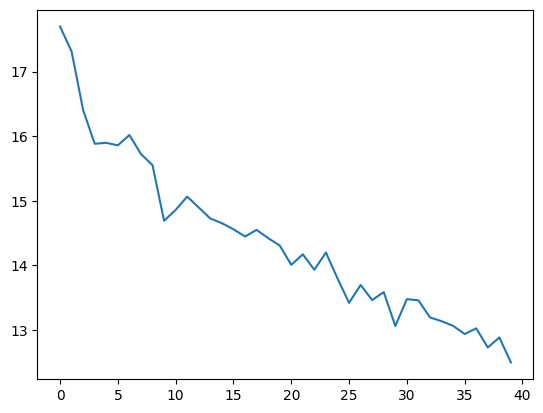

In [ ]:
plt.figure()
plt.plot(all_losses)

## Let's show that it's really about the sequence

In [38]:
def predict_example(name: str):
    rnn.eval()
    with torch.no_grad():
        for i, letter in enumerate(name):
            if i == 0:
                input = letterToTensor(letter)  # [1, 57]
                hidden = rnn.initHidden()  # [1, 128]

            output, hidden = rnn(letterToTensor(letter), hidden)  # output: [1, 18]  hidden: [1, 128]
            print(f"Guess after {letter}: {all_categories[output.argmax()]}")

predict_example('Chevalier')

Guess after C: Irish
Guess after h: Chinese
Guess after e: Chinese
Guess after v: Russian
Guess after a: Russian
Guess after l: French
Guess after i: French
Guess after e: French
Guess after r: French


In [40]:
# Compare with only predicting with the last letter
with torch.no_grad():
    hidden = rnn.initHidden()  # [1, 128]
    output, _ = rnn(letterToTensor('r'), hidden)  # output: [1, 18]
    print(f"Guess: {all_categories[output.argmax()]}")

Guess: German
